# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0 

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [23]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want
print(listings)

[<li class="cl-static-search-result" title="Short term/ vacation Furnished 3BR townhome in lovely neighborhood">
<a href="https://charlottesville.craigslist.org/apa/d/charlottesville-short-term-vacation/7830128067.html">
<div class="title">Short term/ vacation Furnished 3BR townhome in lovely neighborhood</div>
<div class="details">
<div class="price">$90</div>
<div class="location">
                        Charlottesville
                    </div>
</div>
</a>
</li>, <li class="cl-static-search-result" title="Live Above the Many Shops at the Vibrant McIntire Plaza Community!">
<a href="https://charlottesville.craigslist.org/apa/d/charlottesville-live-above-the-many/7830088196.html">
<div class="title">Live Above the Many Shops at the Vibrant McIntire Plaza Community!</div>
<div class="details">
<div class="price">$1,399</div>
<div class="location">
                        221 Hillcrest Road Apt. B
                    </div>
</div>
</a>
</li>, <li class="cl-static-search-result" title=

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [4]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [6]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(71, 6)


,title,price,year,link,brand,age
0,1970 chevelle super sport tribute,54800,1970.0,https://charlottesville.craigslist.org/cto/d/c...,missing,55.0
1,2011 acura mdx,4500,2011.0,https://charlottesville.craigslist.org/cto/d/c...,acura,14.0
2,2008 ford escape xlt 4x4 3.0,1000,2008.0,https://charlottesville.craigslist.org/cto/d/e...,ford,17.0
3,2018 mercedes sprinter 2500 crew van,62800,2018.0,https://charlottesville.craigslist.org/cto/d/b...,missing,7.0
4,truck,6100,NaN,https://charlottesville.craigslist.org/cto/d/s...,missing,NaN


With the data in and wrangled, we can now do some analysis:

count       71.000000
mean     10265.436620
std      11369.372327
min       1000.000000
25%       3775.000000
50%       6700.000000
75%      11250.000000
max      62800.000000
Name: price, dtype: float64


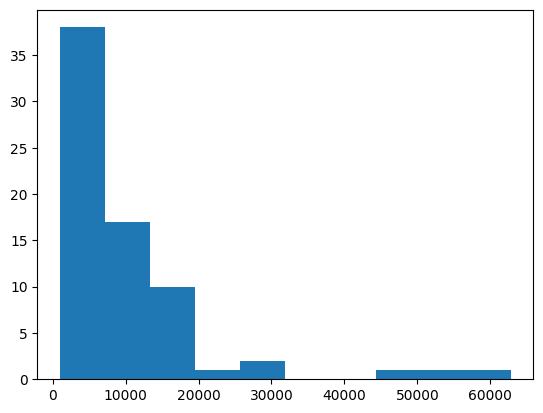

count    66.000000
mean     21.787879
std      15.019490
min       3.000000
25%      13.000000
50%      17.000000
75%      23.500000
max      68.000000
Name: age, dtype: float64


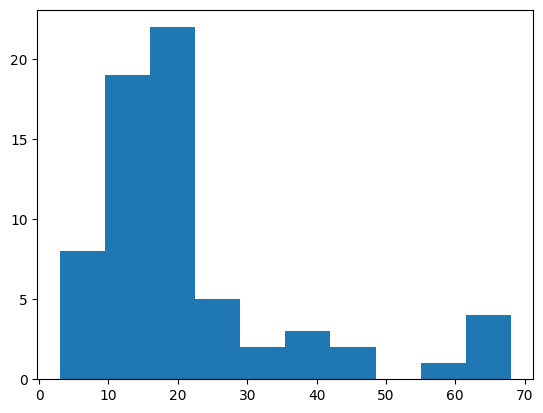

In [7]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [19]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                          \
           count          mean           std      min       25%      50%   
brand                                                                      
audi         1.0  37000.000000           NaN  37000.0  37000.00  37000.0   
bmw          3.0  19966.666667  20813.537261   7900.0   7950.00   8000.0   
chevrolet    4.0  10875.000000   9393.038202   3000.0   3375.00   9000.0   
chevy        3.0  11616.666667  11515.677719   4450.0   4975.00   5500.0   
dodge        1.0  18900.000000           NaN  18900.0  18900.00  18900.0   
ford         3.0  21333.333333  29173.332572   3500.0   4500.00   5500.0   
gmc          2.0  16475.000000  13470.384182   6950.0  11712.50  16475.0   
honda        5.0   5629.800000   2372.328013   2300.0   4700.00   5900.0   
jeep         2.0   9500.000000      0.000000   9500.0   9500.00   9500.0   
lexus        2.0  11175.000000    318.198052  10950.0  11062.50  11175.0   
missing     14.0  10089.214286  16148.241324   2000.0   3312.50   4650.0   
mitsubishi   1.0   7300.000000           NaN   7300.0   7300.00   7300.0   
subaru       1.0   3900.000000           NaN   3900.0   3900.00   3900.0   
toyota       4.0   9549.750000   7072.121340   2199.0   4299.75   9500.0   

                               
                 75%      max  
brand                          
audi        37000.00  37000.0  
bmw         26000.00  44000.0  
chevrolet   16500.00  22500.0  
chevy       15200.00  24900.0  
dodge       18900.00  18900.0  
ford        30250.00  55000.0  
gmc         21237.50  26000.0  
honda        6500.00   8749.0  
jeep         9500.00   9500.0  
lexus       11287.50  11400.0  
missing      6749.75  62800.0  
mitsubishi   7300.00   7300.0  
subaru       3900.00   3900.0  
toyota      14750.00  17000.0

In [8]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
acura        2.0  12.500000   2.121320  11.0  11.75  12.5  13.25  14.0
audi         1.0   8.000000        NaN   8.0   8.00   8.0   8.00   8.0
bmw          3.0  15.666667   1.527525  14.0  15.00  16.0  16.50  17.0
cadillac     1.0  19.000000        NaN  19.0  19.00  19.0  19.00  19.0
chevrolet    4.0  41.250000  19.619293  21.0  32.25  38.0  47.00  68.0
chevy        3.0  21.333333   4.509250  17.0  19.00  21.0  23.50  26.0
dodge        3.0  27.000000   4.582576  22.0  25.00  28.0  29.50  31.0
ford         7.0  15.857143   5.113009   9.0  12.00  17.0  19.50  22.0
gmc          2.0  30.500000  14.849242  20.0  25.25  30.5  35.75  41.0
honda        9.0  10.444444   5.101743   3.0   8.00  11.0  13.00  19.0
jeep         3.0  16.000000   4.358899  13.0  13.50  14.0  17.50  21.0
kia          2.0  15.000000   2.828427  13.0  14.00  15.0  16.00  17.0
lexus        1.0  21.000000        NaN  21.0  21.00  21.0  21.00  21.0
mazda        0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
missing     14.0  33.214286  21.347594   7.0  15.75  26.0  52.75  68.0
mitsubishi   1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
subaru       1.0  10.000000        NaN  10.0  10.00  10.0  10.00  10.0
tesla        1.0   7.000000        NaN   7.0   7.00   7.0   7.00   7.0
toyota       5.0  17.800000   5.263079  12.0  14.00  17.0  21.00  25.0
volkswagen   3.0  25.333333  17.243356  10.0  16.00  22.0  33.00  44.0

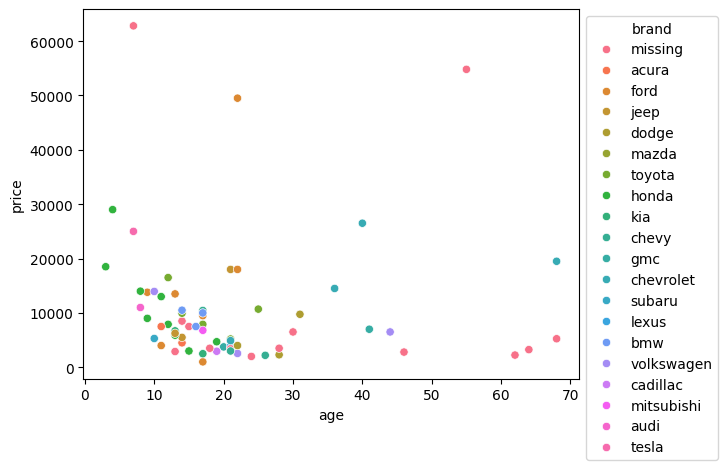

In [9]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.783367 -0.196806
log_age    -0.196806  0.382606
           log_price   log_age
log_price   1.000000 -0.376511
log_age    -0.376511  1.000000


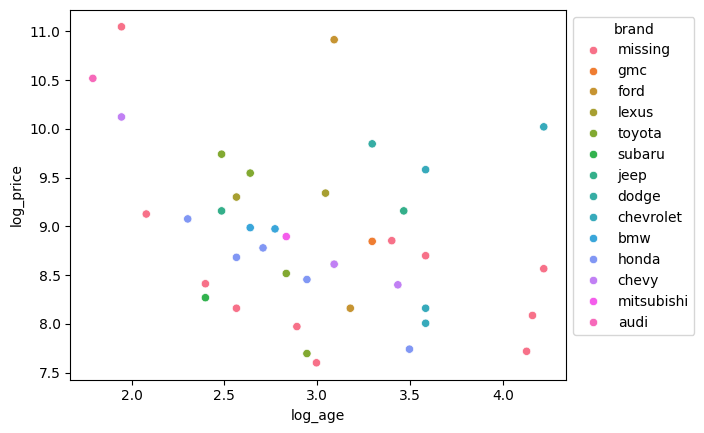

In [22]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

In [ ]:
#Houses- search page

In [30]:
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/apa#search=2~gallery~0' # The page we want to scrape
raw = requests.get(url,headers=header)

In [31]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj_two = soup(raw.content,'html.parser') # Parse the html
listings_lab = bsObj_two.find_all(class_="cl-static-search-result")
print(listings_lab)

[<li class="cl-static-search-result" title="Short term/ vacation Furnished 3BR townhome in lovely neighborhood">
<a href="https://charlottesville.craigslist.org/apa/d/charlottesville-short-term-vacation/7830128067.html">
<div class="title">Short term/ vacation Furnished 3BR townhome in lovely neighborhood</div>
<div class="details">
<div class="price">$90</div>
<div class="location">
                        Charlottesville
                    </div>
</div>
</a>
</li>, <li class="cl-static-search-result" title="Live Above the Many Shops at the Vibrant McIntire Plaza Community!">
<a href="https://charlottesville.craigslist.org/apa/d/charlottesville-live-above-the-many/7830088196.html">
<div class="title">Live Above the Many Shops at the Vibrant McIntire Plaza Community!</div>
<div class="details">
<div class="price">$1,399</div>
<div class="location">
                        221 Hillcrest Road Apt. B
                    </div>
</div>
</a>
</li>, <li class="cl-static-search-result" title=

In [49]:
import re # Regular expressions

types = ['apartment', 'condo', 'cottage/cabin', 'duplex', 'flat', 
         'house', 'in-law', 'loft', 'townhouse', 'manufactured', 
         'assisted living', 'land']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get housing type from the title string:
    words = title.split()
    hits = [word for word in words if word in types] # Find brands in the title
    if len(hits) == 0:
        type = 'missing'
    else:
        type = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'housing type':type})

In [50]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./craigslist_cville_houses.csv') # Save data in case of a disaster
df.head()

(101, 6)


,title,price,year,link,housing type,age
0,short term/ vacation furnished 3br townhome in...,90,NaN,https://charlottesville.craigslist.org/apa/d/c...,missing,NaN
1,live above the many shops at the vibrant mcint...,1399,NaN,https://charlottesville.craigslist.org/apa/d/c...,missing,NaN
2,1 bedroom apartment available may 2025 at the ...,1765,2025.0,https://charlottesville.craigslist.org/apa/d/c...,apartment,0.0
3,1 bedroom apartment available march 13th at th...,1785,NaN,https://charlottesville.craigslist.org/apa/d/c...,apartment,NaN
4,enjoy this pet-friendly & upscale design at 52...,2520,NaN,https://charlottesville.craigslist.org/apa/d/c...,missing,NaN


count     101.000000
mean     1839.099010
std       671.325711
min        65.000000
25%      1449.000000
50%      1800.000000
75%      2030.000000
max      4050.000000
Name: price, dtype: float64


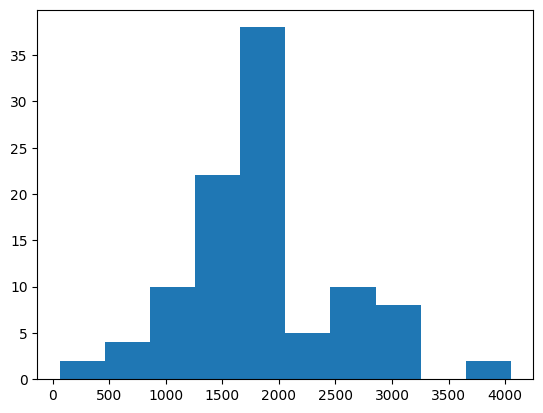

count      6.00000
mean      36.00000
std       55.77096
min        0.00000
25%        0.00000
50%        0.00000
75%       81.00000
max      108.00000
Name: age, dtype: float64


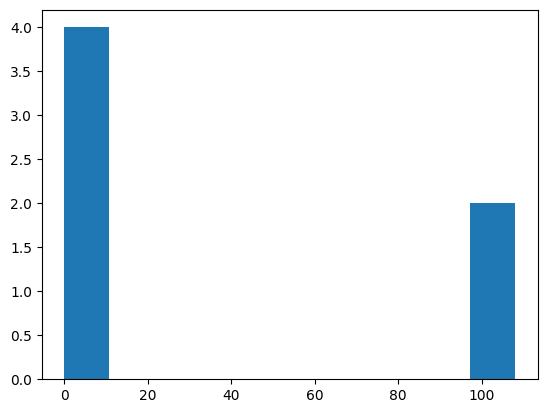

In [51]:
#Price of House Histogram
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
#Age of House Histogram
df['age'].hist(grid=False)
plt.show()

In [52]:
df['age'].value_counts()

age
0.0      4
108.0    2
Name: count, dtype: int64

Upon further investigation, age sucks for houses. Ignore that histogram. Keeping it in for a learning moment.

In [55]:
df.groupby('housing type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
housing type,,,,,,,,
apartment,20.0,1773.700000,565.759490,1000.0,1468.5,1757.5,1843.75,3850.0
condo,1.0,1700.000000,NaN,1700.0,1700.0,1700.0,1700.00,1700.0
duplex,3.0,1674.666667,263.344515,1400.0,1549.5,1699.0,1812.00,1925.0
house,7.0,1462.142857,323.198303,1000.0,1290.0,1395.0,1687.50,1885.0
loft,1.0,1650.000000,NaN,1650.0,1650.0,1650.0,1650.00,1650.0
missing,66.0,1895.787879,748.223527,65.0,1461.5,1855.0,2500.00,4050.0
townhouse,3.0,2181.333333,160.282043,1999.0,2122.0,2245.0,2272.50,2300.0


In [58]:
df.loc[:,['price','housing type']].groupby('housing type').describe()

price                                                            \
             count         mean         std     min     25%     50%      75%   
housing type                                                                   
apartment     20.0  1773.700000  565.759490  1000.0  1468.5  1757.5  1843.75   
condo          1.0  1700.000000         NaN  1700.0  1700.0  1700.0  1700.00   
duplex         3.0  1674.666667  263.344515  1400.0  1549.5  1699.0  1812.00   
house          7.0  1462.142857  323.198303  1000.0  1290.0  1395.0  1687.50   
loft           1.0  1650.000000         NaN  1650.0  1650.0  1650.0  1650.00   
missing       66.0  1895.787879  748.223527    65.0  1461.5  1855.0  2500.00   
townhouse      3.0  2181.333333  160.282043  1999.0  2122.0  2245.0  2272.50   

                      
                 max  
housing type          
apartment     3850.0  
condo         1700.0  
duplex        1925.0  
house         1885.0  
loft          1650.0  
missing       4050.0  
townhouse     2300.0

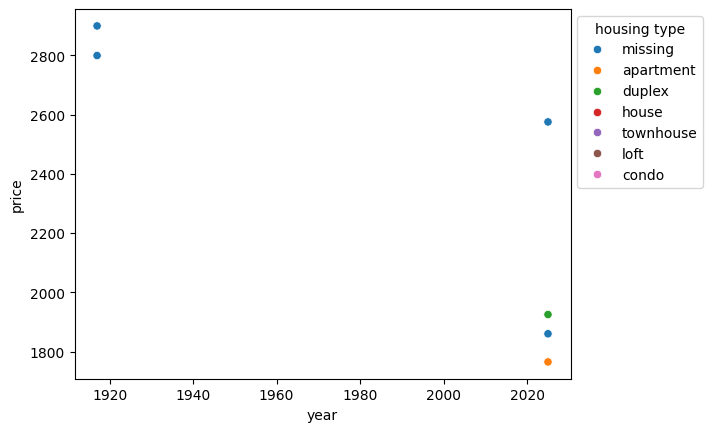

In [59]:
ax = sns.scatterplot(data=df, x='year', y='price',hue='housing type')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Lots of missing values so kind of hard for this scatter plot to provide good analysis.

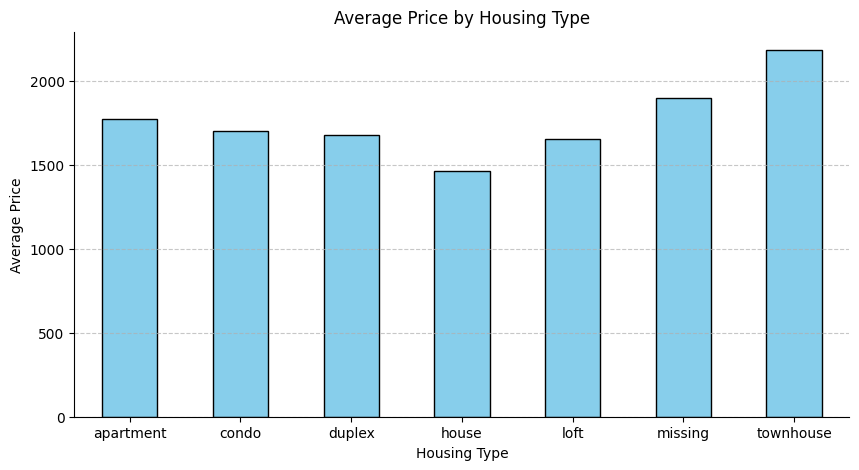

In [69]:
df['housing type'] = df['housing type'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))

housing_prices = df.groupby('housing type')['price'].mean()

#Plotting
housing_prices.plot(kind='bar', figsize=(10,5), color='skyblue', edgecolor='black')

#Labels
plt.xlabel('Housing Type')
plt.ylabel('Average Price')
plt.title('Average Price by Housing Type')
plt.xticks(rotation=360)
plt.grid(axis='y', linestyle='--', alpha=0.7)

#Getting rid of top and bottom spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


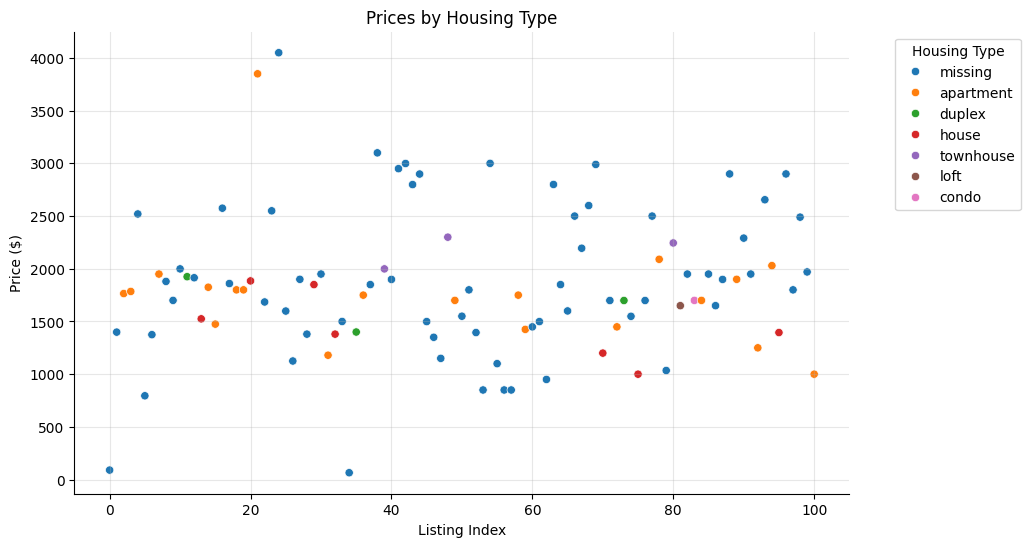

In [70]:
#Creating figure
plt.figure(figsize=(10, 6))

#Scatter plot with color by housing type
sns.scatterplot(data=df, x=df.index, y='price', hue='housing type', palette='tab10')

#Listing index could also be replaced with a more telling numeric variable
plt.xlabel("Listing Index")
plt.ylabel("Price ($)")
plt.title("Prices by Housing Type")
#Get legend off of plot area
plt.legend(title="Housing Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.3)

#Getting rid of top and bottom spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()